<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

## Task 1: Import Packages and Functions

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


## Task 2: Load and Explore Data

In [ ]:
train_df = pd.read_csv('Data/train.csv').fillna(' ')
train_df.sample(10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [ ]:
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [ ]:
# View few toxic comments
train_df.loc[train_df['toxic']==1].sample(10, random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


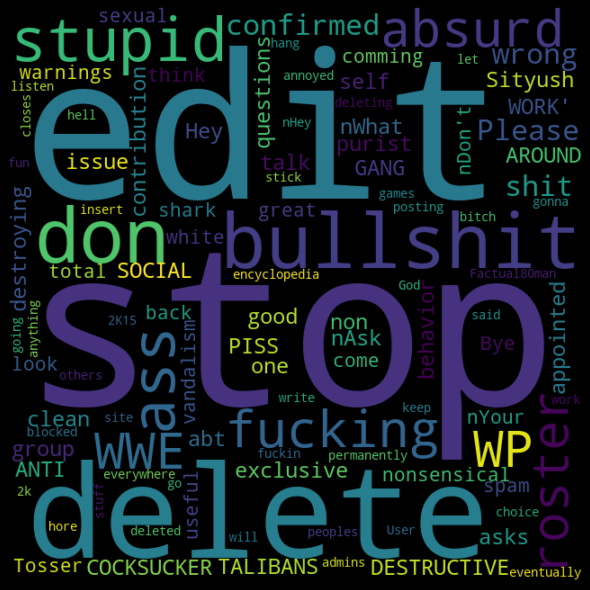

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


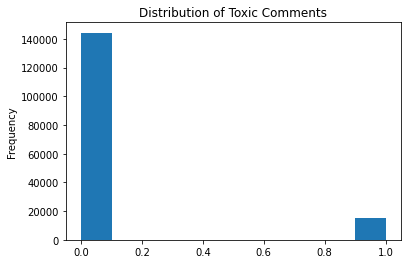

In [ ]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments');

In [ ]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

## Task 3: Data Prep — Tokenize and Pad Text Data

In [ ]:
max_features = 20000
max_text_length = 400

In [ ]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x) #list of lists(containing numbers), so basically a list of sequences, not a numpy array
#pad_sequences:transform a list of num_samples sequences (lists of scalars) into a 2D Numpy array of shape 
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

## Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [ ]:
# Download and extract GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
embedding_dims = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_features, embedding_dims))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

## Task 5: Create Embedding Layer

In [ ]:
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
#load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
#(we don't want to update them during training).
model.add(Embedding(max_features,
                    embedding_dims,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [ ]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [ ]:
# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

# We project onto 6 output layers, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Task 6: Train Model

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1)

In [ ]:
batch_size = 32
epochs = 3

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 43s 10ms/step - loss: 0.1438 - accuracy: 0.9482 - val_loss: 0.1500 - val_accuracy: 0.9537
Epoch 2/3
4239/4239 [==============================] - 43s 10ms/step - loss: 0.1180 - accuracy: 0.9569 - val_loss: 0.1160 - val_accuracy: 0.9578
Epoch 3/3
4239/4239 [==============================] - 43s 10ms/step - loss: 0.1084 - accuracy: 0.9597 - val_loss: 0.1165 - val_accuracy: 0.9606


## Task 7: Evaluate Model

In [ ]:
model.evaluate(x_val, y_val, batch_size=128)

187/187 [==============================] - 3s 13ms/step - loss: 0.1165 - accuracy: 0.9606


[0.11653512716293335, 0.9606450796127319]

In [ ]:
test_df = pd.read_csv('Data/test.csv')

In [ ]:
x_test = test_df['comment_text'].values

In [ ]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [ ]:
y_testing = model.predict(x_testing, verbose = 1, batch_size=32)

4787/4787 [==============================] - 20s 4ms/step


In [ ]:
y_testing.shape

(153164, 1)

In [ ]:
y_testing[0]

array([0.9815887], dtype=float32)

In [ ]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)#.sample(20, random_state=1)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic


## Task 8: Visualize Embeddings

In [ ]:
word_index = x_tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20000, 100)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(max_features):
  word = reverse_word_index[word_num+1]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()